In [3]:
# If you're running this on the same machine as the backend server,
#  you do not need to establish an SSH tunnel

SERVER_URL = "http://127.0.0.1:3000"

In [18]:
from numpy import random
import requests

DELTA_TIME = 0.01

STOP = 0
X_GO = 1
Y_GO = 2

YELLOW_LIGHT_TIME = 6

MAX_CAR_FLOW_RATE = 0.5

def get_next_car(gamma):
    # Assume cars approach the intersection under an exponential distribution
    return random.exponential(gamma, size=1)[0]

class TrafficLight:
    def __init__(self, x_rate, y_rate):
        # https://en.wikipedia.org/wiki/Exponential_distribution#Mean:~:text=1
        self.x_rate_gamma = 1 / x_rate
        self.y_rate_gamma = 1 / y_rate
        self.x_timer = get_next_car(self.x_rate_gamma)
        self.y_timer = get_next_car(self.y_rate_gamma)
        
        self.x_cars = 0
        self.y_cars = 0
        
        self.time = 0
        self.prev_state = STOP
        self.momentum = 0
        self.state = X_GO
        self.transition_timer = 0
    
    def tick(self):
        self.x_timer -= DELTA_TIME
        self.y_timer -= DELTA_TIME
        self.transition_timer -= DELTA_TIME
        
        # Spawn new cars
        if self.x_timer < 0:
            self.x_cars += 1
            self.x_timer = get_next_car(self.x_rate_gamma)
        if self.y_timer < 0:
            self.y_cars += 1
            self.y_timer = get_next_car(self.y_rate_gamma)
        
        # Update momentum (Cars go slow when light first turns green)
        self.momentum = min(self.momentum + (0.05 * DELTA_TIME), MAX_CAR_FLOW_RATE)
        
        # Let cars leave
        if self.state == X_GO:
            self.x_cars = max(self.x_cars - (self.momentum * DELTA_TIME), 0)
        if self.state == Y_GO:
            self.y_cars = max(self.y_cars - (self.momentum * DELTA_TIME), 0)
        
        # Swap lights
        if self.transition_timer < 0:
            old_state = self.state
            if self.state == X_GO or self.state == Y_GO:
                self.state = STOP
                self.transition_timer = YELLOW_LIGHT_TIME
            elif self.state == STOP:
                self.state = X_GO if self.prev_state == Y_GO else Y_GO
                x = requests.get(f"{SERVER_URL}/get_light_times")
                self.transition_timer = int(x.text)
                
            self.prev_state = old_state
            self.momentum = 0
            
        self.time += DELTA_TIME

In [25]:
X_RATE = 0.05 # Cars per second
Y_RATE = 0.20 # Cars per second

SIMULATION_TIME = 1000
total_ticks = int(SIMULATION_TIME / DELTA_TIME)

tl = TrafficLight(X_RATE, Y_RATE)
x_cars = []
y_cars = []
times  = []
states = []
for i in range(total_ticks):
    tl.tick()
    
    # Keep track of certain metrics to plot later
    x_cars.append(tl.x_cars)
    y_cars.append(tl.y_cars)
    states.append(tl.state)
    times.append(tl.time)    # X-axis

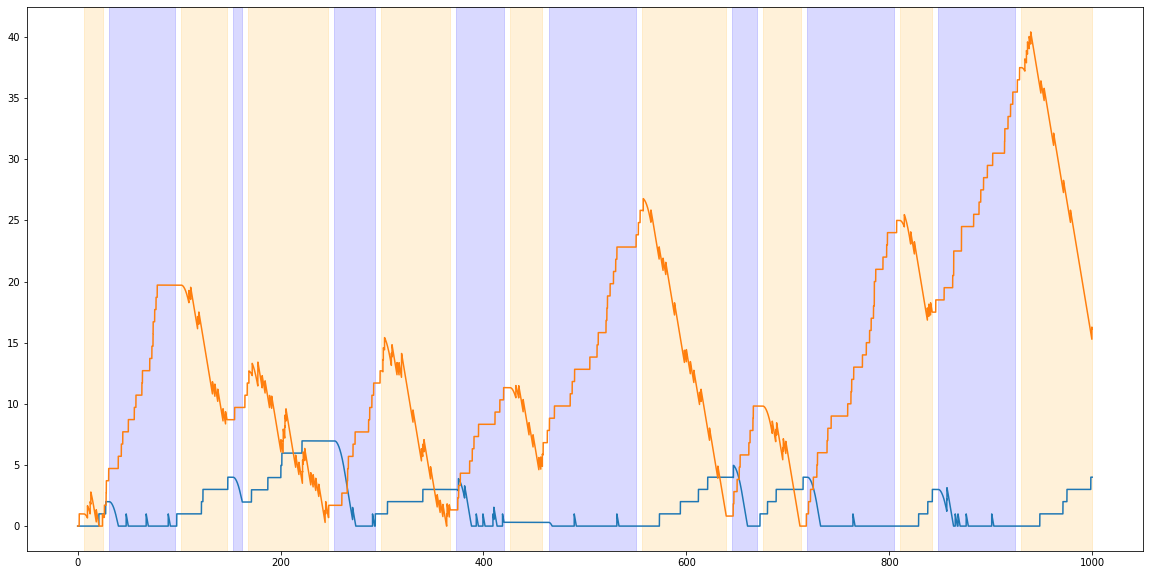

In [26]:
from matplotlib import pyplot as plt

plt.figure(figsize=(20,10)) 


###### GET REGIONS (SEGMENTS) OF X_GO AND Y_GO #######
segments = []
start_index = 0
index = 0
value = states[0]
while True:
    if index >= len(states):
        if not value == STOP: 
            segments.append((start_index, index))
        break
    
    if states[index] != value:
        if not value == STOP: 
            segments.append((start_index, index))
        
        value = states[index]
        start_index = index
    
    index += 1
    
###### SET BACKGROUNDS OF PLOT ######
for i in range(len(segments)):
    col = "orange" if i % 2 == 0 else "blue"
    plt.axvspan(segments[i][0] * DELTA_TIME, segments[i][1] * DELTA_TIME, color=col, alpha=0.15)
    
plt.plot(times, x_cars)
plt.plot(times, y_cars)

plt.show()